In [ ]:
# # # cheking the number of cored this system has.
# !cat /proc/cpuinfo | grep "cpu cores" | uniq

# # GPU info
# !nvidia-smi

# # Amount of system RAM available to be used.
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
# print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

# #finding the recursion limit to avoid Augmentation recursion error 
# import sys
# print(sys.getrecursionlimit())

# #installing fastai
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the data 
#There are NaN values in the consumer_complaint_narrative column
train_raw = pd.read_csv('/content/drive/MyDrive/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
#Training data shape
train_raw.shape

(555957, 18)

In [ ]:
#Preprocessing the data 
#Extracting only those data whose consumer_complaint_narrative column is not null
#columns = 18
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

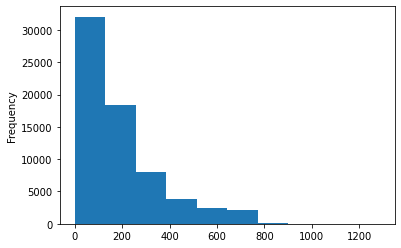

In [ ]:
#It splits the string into , separated values 
train_raw.consumer_complaint_narrative.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [ ]:
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [ ]:
train_raw.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'len_txt'],
      dtype='object')

In [ ]:
train_raw.shape

(66806, 19)

In [ ]:
#Select only the rows with more than 250 words 
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [ ]:
train_raw.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,len_txt
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,666
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,259
190251,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,Consent provided,Web,03/19/2015,Closed with non-monetary relief,Yes,No,1290534,301
190263,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,Consent provided,Web,03/19/2015,Closed with monetary relief,Yes,Yes,1292209,780
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159,558


In [ ]:
#selecting only the consumer_complaint_narrative and product columns
train_raw=train_raw[['consumer_complaint_narrative','product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card', 'Consumer Loan', 'Debt collection',
       'Credit reporting', 'Student loan', 'Bank account or service',
       'Money transfers', 'Payday loan', 'Prepaid card',
       'Other financial service'], dtype=object)

In [ ]:
#group similar products  dataframe.at = accessing a value using row column pair 
train_raw.at[train_raw['product']=='Credit reporting','product']= 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card or prepaid card', 'Consumer Loan',
       'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Student loan', 'Bank account or service', 'Money transfers',
       'Payday loan, title loan, or personal loan',
       'Other financial service'], dtype=object)

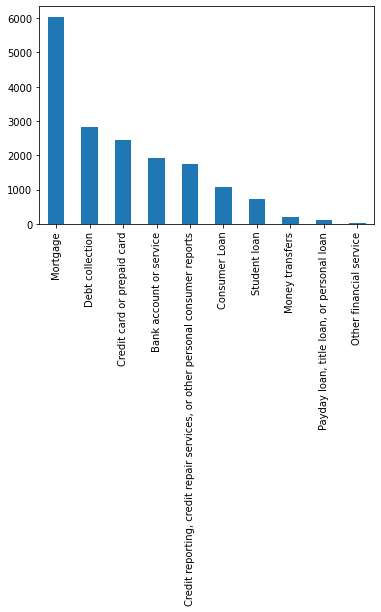

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset 

In [ ]:
#Renaming the columns 
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
#changing the categorical value column to integers

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [ ]:
len(np.unique(train_raw['label']))

10

In [ ]:
#creating the copy of the dataframe
#dataframe.copy(deep=True)  ==> This will create a copy and any changes to the copy will not be reflected in the original df
train = train_raw.copy()

In [ ]:
#reindexing to create randomness 
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
12519,My card with Continental Finance was compromis...,2
13045,I am attempting to sell my home and the closin...,6
7634,On XXXX/XXXX/2015 my lawyer helped me send Ban...,6
9339,"XXXX XXXX, 2015Walmart/Synchrony BankXXXX, GA ...",2
1484,I had my mortgage loan with XXXX for past 10 y...,6


In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
12519,My card with Continental Finance was compromis...,2
13045,I am attempting to sell my home and the closin...,6
7634,On XXXX XXXX 2015 my lawyer helped me send Ban...,6
9339,XXXX XXXX 2015Walmart Synchrony BankXXXX GA XX...,2
1484,I had my mortgage loan with XXXX for past 10 y...,6


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,My card with Continental Finance was compromis...,2
1,I am attempting to sell my home and the closin...,6


In [ ]:
# val.reset_index(drop=True, inplace=True)
# val.head(2)

In [ ]:
# val.shape, train.shape

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

     |████████████████████████████████| 64 kB 2.8 MB/s 


In [ ]:
import bert
from bert import optimization

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('CPU')))

In [ ]:
pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 7.2 MB/s 
     |████████████████████████████████| 352 kB 77.7 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 47.6 MB 68 kB/s 
     |████████████████████████████████| 1.2 MB 91.0 MB/s 
     |████████████████████████████████| 213 kB 96.2 MB/s 
     |████████████████████████████████| 99 kB 10.9 MB/s 


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


# Setting The Output Directory for BERT



In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
OUTPUT_DIR = '/content/drive/MyDrive/Model_CP_NEW_CC'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/MyDrive/Model_CP_NEW_CC *****


In [ ]:
print("Training Set Shape :", train.shape)
# print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (17142, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200] #overlapping 50 words in every chunks 
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def get_split_count(text1):
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  return n

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,My card with Continental Finance was compromis...,2,[My card with Continental Finance was compromi...
1,I am attempting to sell my home and the closin...,6,[I am attempting to sell my home and the closi...
2,On XXXX XXXX 2015 my lawyer helped me send Ban...,6,[On XXXX XXXX 2015 my lawyer helped me send Ba...
3,XXXX XXXX 2015Walmart Synchrony BankXXXX GA XX...,2,[XXXX XXXX 2015Walmart Synchrony BankXXXX GA X...
4,I had my mortgage loan with XXXX for past 10 y...,6,[I had my mortgage loan with XXXX for past 10 ...


In [ ]:
train['text_split_count'] = train[DATA_COLUMN].apply(get_split_count)
train.head()

,text,label,text_split,text_split_count
0,My card with Continental Finance was compromis...,2,[My card with Continental Finance was compromi...,2
1,I am attempting to sell my home and the closin...,6,[I am attempting to sell my home and the closi...,2
2,On XXXX XXXX 2015 my lawyer helped me send Ban...,6,[On XXXX XXXX 2015 my lawyer helped me send Ba...,4
3,XXXX XXXX 2015Walmart Synchrony BankXXXX GA XX...,2,[XXXX XXXX 2015Walmart Synchrony BankXXXX GA X...,2
4,I had my mortgage loan with XXXX for past 10 y...,6,[I had my mortgage loan with XXXX for past 10 ...,2


In [ ]:
count_1 =0
count_2 =0
count_3 =0
count_4 =0
count_5 =0
for i in train['text_split_count']:
  if i==5:
    count_5+=1
  if i==1:
    count_1+=1
  if i==2:
    count_2+=1
  if i==3:
    count_3+=1
  if i==4:
    count_4+=1

In [ ]:
print('count_1 ', count_1)
print('count_2 ', count_2)
print('count_3 ', count_3)
print('count_4 ', count_4)
print('count_5 ', count_5)

count_1  4045
count_2  6873
count_3  3264
count_4  2758
count_5  202


In [ ]:
test_set = train[(train['text_split_count'] == 4)]

In [ ]:
train.shape , test_set.shape

((17142, 4), (2758, 4))

In [ ]:
train = train[(train['text_split_count'].isin([1,2,3,5]))]

In [ ]:
train.shape

(14384, 4)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label,text_split,text_split_count
16866,I was informed today after an excessive runaro...,6,[I was informed today after an excessive runar...,2
12461,I have a loan with New American Funding with a...,6,[I have a loan with New American Funding with ...,3
15195,I refinanced my loan with Greenlight Loans a d...,6,[I refinanced my loan with Greenlight Loans a ...,2
2372,Our mortgage was acquired by Bank of America w...,6,[Our mortgage was acquired by Bank of America ...,2
7817,I WAS ASSESSED ATTORNEY FEES ON XXXX XXXX 15 1...,6,[I WAS ASSESSED ATTORNEY FEES ON XXXX XXXX 15 ...,2


In [ ]:
train.shape, val.shape, test_set.shape

((11507, 4), (2877, 4), (2758, 4))

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(22871, 22871, 22871)

In [ ]:

val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(5722, 5722, 5722)

In [ ]:
test_l = []
test_label_l = []
test_index_l = []
for idx,row in test_set.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_label_l.append(row['label'])
    test_index_l.append(idx)
len(test_l), len(test_label_l), len(test_index_l)

(11032, 11032, 11032)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,I was informed today after an excessive runaro...,6
1,I had been sending 1300 00 a month every month...,6
2,I have a loan with New American Funding with a...,6
3,and was told that due to the new payment syste...,6
4,or I was made to understand so and it appears ...,6


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,I have a XXXX mileage plus credit card with JP...,2
1,does nt notify or disclosure their behaviors o...,2
2,This correspondence is in reference to XXXX I ...,0
3,again calledc on XXXX of XXXX and payment stil...,0
4,I previously had an identity theft situation X...,4


In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df.head()

,text,label
0,On XXXX XXXX 2015 my lawyer helped me send Ban...,6
1,Copy of good faith estimate estimated and fina...,6
2,On XXXX XXXX 2015 after 14 business days XXXX ...,6
3,a XXXX page letter sent XXXX XXXX Mail stating...,6
4,This information is true correct complete not ...,3


In [ ]:
print('train_df shape : ',train_df.shape)
print('val_df shape : ',val_df.shape)
print('test_df shape : ',test_df.shape)

train_df shape :  (22871, 2)
val_df shape :  (5722, 2)
test_df shape :  (11032, 2)


# BERT: Data Preprocessing

In [ ]:
#BERT - Data Preprocessing
#//**Note-BELOW ONE IS NOT WORKING AS THE CLASS "INPUTEXAMPLE" IS PRESENT ONLY THE BERT-TENSORFLOW VERSION 1.0.1 **
#train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                       #            text_a = x[DATA_COLUMN], 
                                                       #            text_b = None, 
                                                       #            label = x[LABEL_COLUMN]), axis = 1)
#AttributeError: module 'official.nlp.bert.run_classifier' has no attribute 'InputExample'
#Getting the above error , so we are using an alternate method to create BERT dataframe 

#Reference : https://towardsdatascience.com/beginners-guide-to-bert-for-multi-classification-task-92f5445c2d7c

In [ ]:
#create a new dataframe for train, dev data 
#<DO NOT USE THIS ONE>
# train_InputExamples = pd.DataFrame({'guid': None,
#     'text_a': train_df[DATA_COLUMN],
#     'text_b': None,
#     'label': train_df[LABEL_COLUMN]})

In [ ]:
# train_InputExamples

In [ ]:

# print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
# print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
# print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
# print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

In [ ]:
#Second refrence 
#https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07E%20-%20Text%20Classification%20with%20BERT%20Deep%20Transfer%20Learning.ipynb#scrollTo=MZ-eiTcDZ6Jw

In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train_df.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

0        <__main__.InputExample object at 0x7f9e3d69af50>
1        <__main__.InputExample object at 0x7f9ea64f1250>
2        <__main__.InputExample object at 0x7f9e3d0cda50>
3        <__main__.InputExample object at 0x7f9ea8bc4890>
4        <__main__.InputExample object at 0x7f9e3cde6310>
                               ...                       
22866    <__main__.InputExample object at 0x7f9e3c8e6bd0>
22867    <__main__.InputExample object at 0x7f9e3c8e6c10>
22868    <__main__.InputExample object at 0x7f9e3c8e6c50>
22869    <__main__.InputExample object at 0x7f9e3c8e6c90>
22870    <__main__.InputExample object at 0x7f9e3c8e6cd0>
Length: 22871, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  I was informed today after an excessive runaround that XXXX XXXX transferred my loan to NationStar This was incredibly shocking to me since I was NEVER notified in ANY way XXXX has had my up to date contact information because I have received tax info from the company in the past Why I was not notified of my loan going to another company I can not understand When I finally spoke with a NationStar representative I found out I was transferred to NationStar XX XX XXXX They received payment for a couplemonths then it stopped Apparently XXXX XXXX never gave them the correct contact info for me either so they were never able to get in touch with me to tell me about the transfer of my loan or how they were not receiving the payments I was sending I was then informed I was 8500 00 behind And yet I had been sending 1300 00 a month every month and NEVER missed a payment actual mortgage payment 9500 00 I understand

In [ ]:
val_InputExamples_1 = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
test_InputExamples_1 = test_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
# import tensorflow.compat.v1 as tf
# #To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
# tf.disable_eager_execution()

In [ ]:
##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
#BERT: Loading the pre-trained model
# bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

# vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
#len(tokenizer.vocab.keys())

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
#print(tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))

In [ ]:
#BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
print(tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))

['i', 'was', 'informed', 'today', 'after', 'an', 'excessive', 'run', '##around', 'that', 'xx', '##xx', 'xx', '##xx', 'transferred', 'my', 'loan', 'to', 'nations', '##tar', 'this', 'was', 'incredibly', 'shocking', 'to', 'me', 'since', 'i', 'was', 'never', 'notified', 'in', 'any', 'way', 'xx', '##xx', 'has', 'had', 'my', 'up', 'to', 'date', 'contact', 'information', 'because', 'i', 'have', 'received', 'tax', 'info', 'from', 'the', 'company', 'in', 'the', 'past', 'why', 'i', 'was', 'not', 'notified', 'of', 'my', 'loan', 'going', 'to', 'another', 'company', 'i', 'can', 'not', 'understand', 'when', 'i', 'finally', 'spoke', 'with', 'a', 'nations', '##tar', 'representative', 'i', 'found', 'out', 'i', 'was', 'transferred', 'to', 'nations', '##tar', 'xx', 'xx', 'xx', '##xx', 'they', 'received', 'payment', 'for', 'a', 'couple', '##mont', '##hs', 'then', 'it', 'stopped', 'apparently', 'xx', '##xx', 'xx', '##xx', 'never', 'gave', 'them', 'the', 'correct', 'contact', 'info', 'for', 'me', 'either', 

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):                             # In case of padding
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)                      # mapping tokens to ids

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.
# train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples_1, label_list, MAX_SEQ_LENGTH, tokenizer)

# val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples_1, label_list, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=200):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels, features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.
MAX_SEQ_LENGTH = 200
train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)

test_features = convert_examples_to_features(tokenizer, test_InputExamples_1, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 11032/11032 [00:36<00:00, 302.18it/s]


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  I was informed today after an excessive runaround that XXXX XXXX transferred my loan to NationStar This was incredibly shocking to me since I was NEVER notified in ANY way XXXX has had my up to date contact information because I have received tax info from the company in the past Why I was not notified of my loan going to another company I can not understand When I finally spoke with a NationStar representative I found out I was transferred to NationStar XX XX XXXX They received payment for a couplemonths then it stopped Apparently XXXX XXXX never gave them the correct contact info for me either so they were never able to get in touch with me to tell me about the transfer of my loan or how they were not receiving the payments I was sending I was then informed I was 8500 00 behind And yet I had been sending 1300 00 a month every month and NEVER missed a payment actual mortgage payment 9500 00 I understand XXXX may have forwarded XX XX XXXX XX XX XXXX to NS That still leaves 

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(1429, 10)

In [ ]:
#Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/Model_CP_NEW_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/Model_CP_NEW_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# Create an input function for testing. drop_remainder = True for using TPUs.
test_input_fn = input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#BERT: Fine Tuning Training & Evaluating
print(f'Beginning Training!')
#current_time = datetime.time()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.6753201, step = 0


INFO:tensorflow:loss = 2.6753201, step = 0


INFO:tensorflow:global_step/sec: 2.05084


INFO:tensorflow:global_step/sec: 2.05084


INFO:tensorflow:loss = 1.5297492, step = 100 (48.762 sec)


INFO:tensorflow:loss = 1.5297492, step = 100 (48.762 sec)


INFO:tensorflow:global_step/sec: 2.48168


INFO:tensorflow:global_step/sec: 2.48168


INFO:tensorflow:loss = 0.7979175, step = 200 (40.295 sec)


INFO:tensorflow:loss = 0.7979175, step = 200 (40.295 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 1.73807


INFO:tensorflow:global_step/sec: 1.73807


INFO:tensorflow:loss = 0.28139877, step = 300 (57.535 sec)


INFO:tensorflow:loss = 0.28139877, step = 300 (57.535 sec)


INFO:tensorflow:global_step/sec: 2.48116


INFO:tensorflow:global_step/sec: 2.48116


INFO:tensorflow:loss = 0.7239708, step = 400 (40.304 sec)


INFO:tensorflow:loss = 0.7239708, step = 400 (40.304 sec)


INFO:tensorflow:global_step/sec: 2.48247


INFO:tensorflow:global_step/sec: 2.48247


INFO:tensorflow:loss = 0.37031972, step = 500 (40.282 sec)


INFO:tensorflow:loss = 0.37031972, step = 500 (40.282 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 1.77609


INFO:tensorflow:global_step/sec: 1.77609


INFO:tensorflow:loss = 0.4671146, step = 600 (56.303 sec)


INFO:tensorflow:loss = 0.4671146, step = 600 (56.303 sec)


INFO:tensorflow:global_step/sec: 2.48212


INFO:tensorflow:global_step/sec: 2.48212


INFO:tensorflow:loss = 0.37608016, step = 700 (40.288 sec)


INFO:tensorflow:loss = 0.37608016, step = 700 (40.288 sec)


INFO:tensorflow:global_step/sec: 2.48222


INFO:tensorflow:global_step/sec: 2.48222


INFO:tensorflow:loss = 0.36202297, step = 800 (40.287 sec)


INFO:tensorflow:loss = 0.36202297, step = 800 (40.287 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 1.78168


INFO:tensorflow:global_step/sec: 1.78168


INFO:tensorflow:loss = 0.4209003, step = 900 (56.127 sec)


INFO:tensorflow:loss = 0.4209003, step = 900 (56.127 sec)


INFO:tensorflow:global_step/sec: 2.48172


INFO:tensorflow:global_step/sec: 2.48172


INFO:tensorflow:loss = 0.2682234, step = 1000 (40.295 sec)


INFO:tensorflow:loss = 0.2682234, step = 1000 (40.295 sec)


INFO:tensorflow:global_step/sec: 2.48217


INFO:tensorflow:global_step/sec: 2.48217


INFO:tensorflow:loss = 0.5620487, step = 1100 (40.287 sec)


INFO:tensorflow:loss = 0.5620487, step = 1100 (40.287 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 1.6988


INFO:tensorflow:global_step/sec: 1.6988


INFO:tensorflow:loss = 0.3243076, step = 1200 (58.865 sec)


INFO:tensorflow:loss = 0.3243076, step = 1200 (58.865 sec)


INFO:tensorflow:global_step/sec: 2.48151


INFO:tensorflow:global_step/sec: 2.48151


INFO:tensorflow:loss = 0.3604904, step = 1300 (40.298 sec)


INFO:tensorflow:loss = 0.3604904, step = 1300 (40.298 sec)


INFO:tensorflow:global_step/sec: 2.48202


INFO:tensorflow:global_step/sec: 2.48202


INFO:tensorflow:loss = 0.46636862, step = 1400 (40.290 sec)


INFO:tensorflow:loss = 0.46636862, step = 1400 (40.290 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1429...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1429...


INFO:tensorflow:Saving checkpoints for 1429 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1429 into /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1429...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1429...


INFO:tensorflow:Loss for final step: 0.96083117.


INFO:tensorflow:Loss for final step: 0.96083117.


In [ ]:
#Run this If you want to load the model 
#Loading a specific check point : 
# warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1800.meta')


# model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps)

# estimator=tf.estimator.Estimator(model_fn=model_fn,
#                        config=run_config,
#                        params={"batch_size": BATCH_SIZE},
#                        warm_start_from=warm_start)

In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-11-15T19:38:55


INFO:tensorflow:Starting evaluation at 2021-11-15T19:38:55


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 50.96052s


INFO:tensorflow:Inference Time : 50.96052s


INFO:tensorflow:Finished evaluation at 2021-11-15-19:39:46


INFO:tensorflow:Finished evaluation at 2021-11-15-19:39:46


INFO:tensorflow:Saving dict for global step 1429: eval_accuracy = 0.8509262, false_negatives = 125.0, false_positives = 127.0, global_step = 1429, loss = 0.51820546, true_negatives = 517.0, true_positives = 4953.0


INFO:tensorflow:Saving dict for global step 1429: eval_accuracy = 0.8509262, false_negatives = 125.0, false_positives = 127.0, global_step = 1429, loss = 0.51820546, true_negatives = 517.0, true_positives = 4953.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1429: /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1429: /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


{'eval_accuracy': 0.8509262,
 'false_negatives': 125.0,
 'false_positives': 127.0,
 'global_step': 1429,
 'loss': 0.51820546,
 'true_negatives': 517.0,
 'true_positives': 4953.0}

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-11-15T19:40:02


INFO:tensorflow:Starting evaluation at 2021-11-15T19:40:02


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 92.95380s


INFO:tensorflow:Inference Time : 92.95380s


INFO:tensorflow:Finished evaluation at 2021-11-15-19:41:35


INFO:tensorflow:Finished evaluation at 2021-11-15-19:41:35


INFO:tensorflow:Saving dict for global step 1429: eval_accuracy = 0.8376541, false_negatives = 328.0, false_positives = 273.0, global_step = 1429, loss = 0.5328692, true_negatives = 1047.0, true_positives = 9384.0


INFO:tensorflow:Saving dict for global step 1429: eval_accuracy = 0.8376541, false_negatives = 328.0, false_positives = 273.0, global_step = 1429, loss = 0.5328692, true_negatives = 1047.0, true_positives = 9384.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1429: /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1429: /content/drive/MyDrive/Model_CP_NEW_CC/model.ckpt-1429


{'eval_accuracy': 0.8376541,
 'false_negatives': 328.0,
 'false_positives': 273.0,
 'global_step': 1429,
 'loss': 0.5328692,
 'true_negatives': 1047.0,
 'true_positives': 9384.0}

# Extract Embeddings from BERT

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  #input_features = convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_features = convert_examples_to_features(tokenizer,input_examples,MAX_SEQ_LENGTH )
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape

((22871, 2), (5722, 2))

In [ ]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 22871/22871 [01:13<00:00, 309.90it/s]


In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

Converting examples to features: 100%|██████████| 5722/5722 [00:18<00:00, 313.93it/s]


(5722, 768)

In [ ]:
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 11032/11032 [00:35<00:00, 308.55it/s]


In [ ]:
tr_emb.shape, val_emb.shape, test_emb.shape

((22871, 768), (5722, 768), (11032, 768))

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

11507

In [ ]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.86072046, 0.43798667, -0.7019593, -0.88125...",6
1,"[[0.9019492, 0.05607622, -0.26593843, -0.92448...",6
2,"[[0.8820344, 0.3613367, -0.7108693, -0.8903254...",6
3,"[[0.8209958, 0.6560065, -0.57341295, -0.896481...",6
4,"[[0.89665663, 0.27449828, 0.09723861, -0.96131...",6


In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.9061749, 0.41015404, 0.6649685, -0.122788...",2
1,"[[-0.31267247, -0.1406635, 0.5538943, -0.63370...",0
2,"[[0.694341, 0.32753816, 0.77483904, -0.5109974...",4
3,"[[0.79286414, -0.37492448, -0.19703907, -0.813...",1
4,"[[0.22756599, -0.34257317, -0.7038676, 0.60045...",3


In [ ]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
telabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  telabel_l_final.append(test_set.loc[k]['label'])

df_test = pd.DataFrame({'emb': test_l_final, 'label': telabel_l_final})
df_test.head()

,emb,label
0,"[[0.77756655, 0.6698861, -0.4963346, -0.904869...",6
1,"[[0.49540016, 0.51043004, -0.6766944, -0.40249...",3
2,"[[0.76287097, -0.34154505, -0.6350638, -0.7079...",4
3,"[[0.8625518, -0.43675116, 0.29617095, -0.91736...",6
4,"[[0.7242977, 0.36210737, 0.5060949, -0.8694733...",6


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11507, 2), (2877, 2), (2758, 2))

In [ ]:
# import pickle

# pickle_out = open("/content/drive/MyDrive/AEdf_train_cc.pickle","wb")
# pickle.dump(df_train, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/MyDrive/AEdf_val_cc.pickle","wb")
# pickle.dump(df_val, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/MyDrive/AEdf_test_cc.pickle","wb")
# pickle.dump(df_test, pickle_out)
# pickle_out.close()

In [ ]:
# len(df_train['emb'][0])

## **Autoencoders**

In [ ]:
# import pickle

In [ ]:
# pickle_in = open("/content/drive/MyDrive/AEdf_train_cc.pickle","rb")
# df_train = pickle.load(pickle_in)

# pickle_in = open("/content/drive/MyDrive/AEdf_val_cc.pickle","rb")
# df_val = pickle.load(pickle_in)

# pickle_in = open("/content/drive/MyDrive/AEdf_test_cc.pickle","rb")
# df_test = pickle.load(pickle_in)

In [ ]:
def finding_mean(mat):
    return np.mean(mat, axis=0)

In [ ]:
df_train['mean_emb'] = df_train['emb'].apply(finding_mean)

In [ ]:
df_val['mean_emb'] = df_val['emb'].apply(finding_mean)

In [ ]:
df_test['mean_emb'] = df_test['emb'].apply(finding_mean)

In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_val.head(2)

,emb,label,mean_emb
0,"[[-0.9061749, 0.41015404, 0.6649685, -0.122788...",2,"[-0.91931015, 0.18508063, 0.6228454, -0.103337..."
1,"[[-0.31267247, -0.1406635, 0.5538943, -0.63370...",0,"[-0.19657195, -0.25499365, 0.48945713, -0.6833..."


In [ ]:
df_test.reset_index(drop=True, inplace=True)
df_test.head(2)

,emb,label,mean_emb
0,"[[0.77756655, 0.6698861, -0.4963346, -0.904869...",6,"[0.36100292, 0.35160166, -0.21518295, -0.82993..."
1,"[[0.49540016, 0.51043004, -0.6766944, -0.40249...",3,"[0.50985795, 0.15801601, -0.70547223, 0.025880..."


In [ ]:
train_x =np.array(df_train['mean_emb'])

In [ ]:
train_x[0].shape

(768,)

In [ ]:
dev_x =np.array(df_val['mean_emb'])
test_x = np.array(df_test['mean_emb'])

In [ ]:
train_x.shape, dev_x.shape, test_x.shape

((11507,), (2877,), (2758,))

In [ ]:
train_x.shape

(11507,)

In [ ]:
# len(train_x[0][])

In [ ]:
import sys

In [ ]:
x_train=[]
y_train=[]
for i in range(df_train.shape[0]):
  x_train.append(df_train["mean_emb"][i])
  y_train.append(df_train["label"][i])

X = np.array(x_train)
y = np.array(y_train)

In [ ]:
x_val = []
y_val = []
for i in range(df_val.shape[0]):
  x_val.append(df_val["mean_emb"][i])
  y_val.append(df_val["label"][i])

X_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
x_test=[]
y_test=[]
for i in range(df_test.shape[0]):
  x_test.append(df_test["mean_emb"][i])
  y_test.append(df_test["label"][i])

X_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
X.shape, X_val.shape, X_test.shape

((11507, 768), (2877, 768), (2758, 768))

In [ ]:
X

array([[ 0.88277185,  0.52090144, -0.68227226, ..., -0.9726062 ,
        -0.08058631, -0.65581596],
       [ 0.61674076,  0.08631352, -0.2646845 , ..., -0.8255411 ,
        -0.18265043, -0.61337215],
       [ 0.8846793 ,  0.16234295, -0.5977392 , ..., -0.928701  ,
        -0.13180985, -0.5424822 ],
       ...,
       [ 0.6516204 ,  0.5347675 , -0.6124982 , ..., -0.93891   ,
        -0.1506753 , -0.69749194],
       [ 0.8400519 ,  0.59478617, -0.54205006, ..., -0.97618085,
        -0.09541523, -0.46909273],
       [ 0.5189385 ,  0.22839591,  0.06082961, ..., -0.87783027,
        -0.05065242, -0.7075019 ]], dtype=float32)

In [ ]:
# X_train = X.reshape((X.shape[1], -1))
# X_train.shape
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
train_y = np.array(df_train['label'])
dev_y = np.array(df_val['label'])
test_y = np.array(df_test['label'])

In [ ]:
train_y.shape, dev_y.shape, test_y.shape

((11507,), (2877,), (2758,))

In [ ]:
# def input_generator(df):
#     x_list= df['emb'].to_list()
#     y_list= df.label.to_list()
#     timesteps = len(max(df['emb'].to_list(), key=len))
#     x_train= np.full((df['emb'].shape[0], timesteps, 768), -99.)
#     y_train = np.zeros((df['emb'].shape[0],  1))
#     for b in range(len(x_list)):
#         x_train[b, 0:len(x_list[b]), :] = x_list[b]
#         y_train[b]=y_list[b]
#     return x_train, y_train

In [ ]:
# x_train_new,y_train_new=input_generator(df_train)
# x_train_new.shape, y_train_new.shape

In [ ]:
# x_val_new,y_val_new=input_generator(df_val)
# x_val_new.shape, y_val_new.shape

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 500)               384500    
                                                                 
 dense_1 (Dense)             (None, 768)               384768    
                                                                 
Total params: 769,268
Trainable params: 769,268
Non-trainable params: 0
_________________________________________________________________
Train on 11507 samples, validate on 2877 samples
Epoch 1/50
11507/11507 [==============================] - 0s 22us/sample - loss: -9.9111 - mean_squared_error: 0.2788 - val_loss: -35.6596 - val_mean_squared_error: 0.2533
Epoch 2/50
11507/11507 [==============================] - 0s 12us/sample - loss: -103.5911 - mean_

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 3/50
11507/11507 [==============================] - 0s 12us/sample - loss: -351.5072 - mean_squared_error: 0.2754 - val_loss: -532.7300 - val_mean_squared_error: 0.2755
Epoch 4/50
11507/11507 [==============================] - 0s 12us/sample - loss: -772.2488 - mean_squared_error: 0.2798 - val_loss: -1040.8783 - val_mean_squared_error: 0.2786
Epoch 5/50
11507/11507 [==============================] - 0s 12us/sample - loss: -1371.4495 - mean_squared_error: 0.2824 - val_loss: -1722.2722 - val_mean_squared_error: 0.2810
Epoch 6/50
11507/11507 [==============================] - 0s 12us/sample - loss: -2148.7060 - mean_squared_error: 0.2839 - val_loss: -2578.2071 - val_mean_squared_error: 0.2820
Epoch 7/50
11507/11507 [==============================] - 0s 12us/sample - loss: -3100.6697 - mean_squared_error: 0.2848 - val_loss: -3608.2596 - val_mean_squared_error: 0.2837
Epoch 8/50
11507/11507 [==============================] - 0s 13us/sample - loss: -4226.1615 - mean_squared_error: 0.28

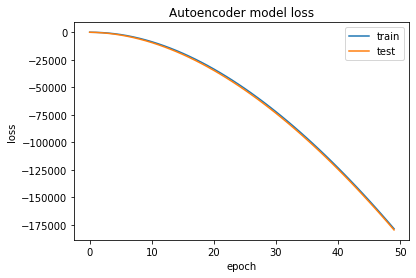

In [ ]:
encoding_dim = 500

# Define input layer
input_data = Input(shape=(768,))
# Define encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_data)
# Define decoding layer
decoded = Dense(768, activation='sigmoid')(encoded)
# Create the autoencoder model
autoencoder = Model(input_data, decoded)
#Compile the autoencoder model
autoencoder.compile(metrics = ['mse'],
                    optimizer='adam',
                    loss='binary_crossentropy')

autoencoder.summary()

#Fit to train set, validate with dev set and save to hist_auto for plotting purposes
hist_auto = autoencoder.fit(X, X, epochs = 50, batch_size=256, shuffle=True, validation_data=(X_val, X_val))
#(train_x, train_x, epochs=50)
#, batch_size=256, shuffle=True, validation_data=(dev_x, dev_x))

# Summarize history for loss
plt.figure()
plt.plot(hist_auto.history['loss'])
plt.plot(hist_auto.history['val_loss'])
plt.title('Autoencoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
encoder = Model(input_data, encoded)
encoded_X_train = encoder.predict(X)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
encoded_X_train.shape

(11507, 500)

In [ ]:
type(encoded_X_train)

numpy.ndarray

In [ ]:
df_train['emb']

0        [[0.86072046, 0.43798667, -0.7019593, -0.88125...
1        [[0.9019492, 0.05607622, -0.26593843, -0.92448...
2        [[0.8820344, 0.3613367, -0.7108693, -0.8903254...
3        [[0.8209958, 0.6560065, -0.57341295, -0.896481...
4        [[0.89665663, 0.27449828, 0.09723861, -0.96131...
                               ...                        
11502    [[-0.8018979, 0.55015033, 0.7057307, 0.0552690...
11503    [[0.5490496, -0.11912848, -0.40134892, 0.06064...
11504    [[0.75658625, 0.612969, -0.49684045, -0.929034...
11505    [[0.87606156, 0.7177452, -0.5851185, -0.911565...
11506    [[0.5189385, 0.22839591, 0.060829613, -0.81515...
Name: emb, Length: 11507, dtype: object

In [ ]:
encoded_X_train

array([[1517.483  ,  902.2807 ,  539.0067 , ..., 1469.3584 , 1502.5675 ,
        1523.825  ],
       [1105.2904 ,  640.0748 ,  379.25452, ..., 1084.1586 , 1104.5028 ,
        1115.0417 ],
       [1377.4242 ,  756.4853 ,  417.27637, ..., 1322.934  , 1363.9381 ,
        1390.9319 ],
       ...,
       [1377.9648 ,  751.7689 ,  410.5109 , ..., 1336.8287 , 1372.3243 ,
        1393.9805 ],
       [1423.5773 ,  962.9494 ,  647.0609 , ..., 1394.259  , 1412.9877 ,
        1423.6353 ],
       [1140.3612 ,  526.7482 ,  222.36778, ..., 1113.8922 , 1135.4374 ,
        1152.1921 ]], dtype=float32)

In [ ]:
encoder = Model(input_data, encoded)
encoded_X_val = encoder.predict(X_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
encoded_X_val.shape

(2877, 500)

In [ ]:
encoder = Model(input_data, encoded)
encoded_X_test = encoder.predict(X_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
encoded_X_test.shape

(2758, 500)

In [ ]:
# from keras import layers
# from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
# from keras.models import Sequential, Model
text_input = Input(shape=(None,500,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(10, activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 500)]       0         
                                                                 
 masking (Masking)           (None, None, 500)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               240400    
                                                                 
 dense_2 (Dense)             (None, 30)                3030      
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
Total params: 243,740
Trainable params: 243,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_new = []
for i in range(len(encoded_X_train)):
  train_new.append(encoded_X_train[i])

val_new = []
for i in range(len(encoded_X_val)):
  val_new.append(encoded_X_val[i])

In [ ]:
test_new = []
for i in range(len(encoded_X_test)):
  test_new.append(encoded_X_test[i])

In [ ]:
len(train_new)

11507

In [ ]:
df_train_AE = pd.DataFrame({'emb': train_new, 'label': df_train['label'], })
df_train_AE.head()

,emb,label
0,"[1517.483, 902.2807, 539.0067, 1498.6249, 1127...",6
1,"[1105.2904, 640.0748, 379.25452, 1087.3875, 82...",6
2,"[1377.4242, 756.4853, 417.27637, 1350.9982, 95...",6
3,"[1505.2328, 861.1341, 493.4098, 1486.0038, 111...",6
4,"[1013.6584, 770.75287, 559.64703, 1022.967, 98...",6


In [ ]:
df_val_AE = pd.DataFrame({'emb': val_new, 'label': df_val['label'], })
df_val_AE.head()

,emb,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1065.4135, 0.0, 0.0,...",2
1,"[230.17505, 262.93018, 233.11201, 234.16603, 3...",0
2,"[0.0, 676.7934, 885.03827, 0.0, 509.49176, 621...",4
3,"[835.08984, 631.3322, 472.1651, 830.15875, 740...",1
4,"[0.0, 485.10248, 754.0275, 0.0, 10.569611, 126...",3


In [ ]:
df_test_AE = pd.DataFrame({'emb': test_new, 'label': df_test['label'], })
df_test_AE.head()

,emb,label
0,"[1079.2384, 681.64453, 438.77838, 1066.606, 85...",6
1,"[167.1105, 734.3476, 877.459, 178.93819, 354.4...",3
2,"[402.3811, 672.95294, 712.37994, 409.66428, 51...",4
3,"[1199.3936, 846.57007, 597.6043, 1189.6061, 97...",6
4,"[869.47015, 753.8413, 608.0529, 878.2892, 892....",6


In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 37
batches_per_epoch =  311
assert batch_size * batches_per_epoch == num_sequences
num_features= 500
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 21
batches_per_epoch_val = 137
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 500
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
# model.fit(df_train_AE['emb'], df_train_AE['label'], steps_per_epoch=batches_per_epoch, epochs=10,
#                     validation_data=(df_val_AE['emb'], df_val_AE['label']), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

In [ ]:
model.fit_generator(train_generator(df_train_AE), steps_per_epoch=batches_per_epoch, epochs=100,
                    validation_data=val_generator(df_val_AE), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
311/311 [==============================] - ETA: 0s - batch: 155.0000 - size: 37.0000 - loss: 0.8514 - acc: 0.7762

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


311/311 [==============================] - 145s 463ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.8514 - acc: 0.7762 - val_loss: 0.7796 - val_acc: 0.7696 - lr: 0.0010
Epoch 2/100
311/311 [==============================] - 143s 460ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.6691 - acc: 0.8008 - val_loss: 0.7568 - val_acc: 0.7775 - lr: 0.0010
Epoch 3/100
311/311 [==============================] - 144s 462ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.6222 - acc: 0.8057 - val_loss: 0.7461 - val_acc: 0.7730 - lr: 0.0010
Epoch 4/100
311/311 [==============================] - 144s 462ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.6338 - acc: 0.8067 - val_loss: 0.7250 - val_acc: 0.7901 - lr: 0.0010
Epoch 5/100
311/311 [==============================] - 143s 461ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.6189 - acc: 0.8072 - val_loss: 0.7142 - val_acc: 0.7883 - lr: 0.0010
Epoch 6/100
311/311 [==============================] - 143s 460ms/step - batch: 155.0000 - s

In [ ]:
#test

In [ ]:
model.fit_generator(train_generator(df_train_AE), steps_per_epoch=batches_per_epoch, epochs=50,
                    validation_data=val_generator(df_val_AE), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/50
311/311 [==============================] - ETA: 0s - batch: 155.0000 - size: 37.0000 - loss: 1.0465 - acc: 0.7193

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


311/311 [==============================] - 212s 678ms/step - batch: 155.0000 - size: 37.0000 - loss: 1.0465 - acc: 0.7193 - val_loss: 0.9377 - val_acc: 0.7355 - lr: 0.0010
Epoch 2/50
311/311 [==============================] - 209s 673ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.7392 - acc: 0.7942 - val_loss: 0.8110 - val_acc: 0.7417 - lr: 0.0010
Epoch 3/50
311/311 [==============================] - 209s 674ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.7621 - acc: 0.7545 - val_loss: 0.8435 - val_acc: 0.7205 - lr: 0.0010
Epoch 4/50
311/311 [==============================] - ETA: 0s - batch: 155.0000 - size: 37.0000 - loss: 0.7697 - acc: 0.7502
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
311/311 [==============================] - 208s 670ms/step - batch: 155.0000 - size: 37.0000 - loss: 0.7697 - acc: 0.7502 - val_loss: 0.8601 - val_acc: 0.7216 - lr: 0.0010
Epoch 5/50
311/311 [==============================] - 209s 672ms/step - batch: 155.00

In [ ]:
num_sequences_val = len(df_test['mean_emb'].to_list())
batch_size_val = 14
batches_per_epoch_val = 197
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 500
model.evaluate_generator(val_generator(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.5928055007899473, 0.82160985]

In [ ]:
y_proba=model.predict(val_generator(df_test_AE), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test_AE['label']))
print('Classification Report')
print(classification_report(y_pred, df_test_AE['label']))

Confusion Matrix
[[ 247    5   57    0    2   13    8    1    0    1]
 [   5   60   13   29   18    1    7    0    0    2]
 [  59   14  272    6   23    5    1    2    0    2]
 [   2    3    3  121    0    0    0    0    0    3]
 [   2   49    9   25  236    0   11    0    4   23]
 [   2    0    1    0    0   15    0    0    0    0]
 [  13   18    2    1   30    1 1242    0    0   13]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    1    0    0    1    0   73]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       334
           1       0.40      0.44      0.42       135
           2       0.76      0.71      0.73       384
           3       0.66      0.92      0.77       132
           4       0.76      0.66      0.71       359
           5       0.43      0.83      0.57        18
           6       0.98      0.94      0.96      13

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test_AE['label'])

In [ ]:
diag = np.diagonal(mat)
sum(diag)

2266

In [ ]:
sum(sum(mat))-sum(diag)

492